In [1]:
#Installing pyspark, spark-nlp and findspark

!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-12-24 14:54:34--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2021-12-24 14:54:35--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-12-24 14:54:35--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:44

In [2]:
#To check contents of colab.sh, colab.sh will be downloaded

!wget http://setup.johnsnowlabs.com/colab.sh 

! cat /content/colab.sh

--2021-12-24 14:55:27--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2021-12-24 14:55:27--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-12-24 14:55:28--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:44

In [3]:
#Calling all the necessary libraries
import pandas as pd
import numpy as np
import os

#Loading all the spark related libraries
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, StringType,StructField,StructType
from pyspark.sql.functions import regexp_replace

from matplotlib import pyplot as plt
import seaborn as sns

#Loading all the Spark-nlp related libraries
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline 
from pyspark.ml.feature import CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover
from pyspark.sql.functions import col, udf,regexp_replace,isnull
from pyspark.sql.types import StringType,IntegerType
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [4]:
#Creating a Spark session
spark = sparknlp.start()

In [5]:
#Show multiple command outputs from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [10]:
#Mount gdrive to read data
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [11]:
path = os.chdir("/gdrive/MyDrive/fa_project/")
data_df = pd.read_csv('dataset.csv', encoding='latin')
data_df.head()

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training


In [12]:
reviews = pd.read_csv('dataset.csv', encoding='latin')
courses = pd.read_csv('courses_dataset.csv', encoding='latin')

merged_reviews_courses = pd.merge(reviews,courses,on = 'course_id')
merged_reviews_courses.head()

,reviews,reviewers,date_reviews,rating,course_id,name,institution,course_url
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...


In [13]:
data_df.shape

(8080, 5)

In [14]:
data_df['rating'].value_counts()

5    6985
4     846
3     111
1      87
2      51
Name: rating, dtype: int64

In [15]:
print(merged_reviews_courses.shape)

(8080, 8)


In [16]:
top_reviewed_courses = merged_reviews_courses.name.value_counts()
top_reviewed_courses.head(10)

Financial Markets                                           7993
Become a CBRS Certified Professional Installer by Google      87
Name: name, dtype: int64

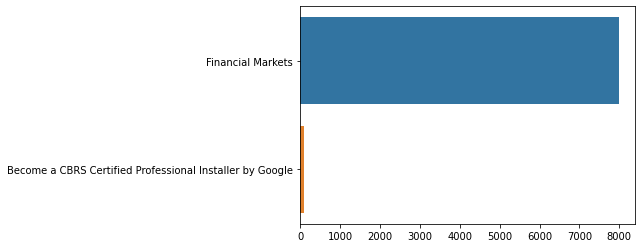

In [17]:
sns.barplot(x = top_reviewed_courses.head(10).values ,y =top_reviewed_courses.head(10).index)

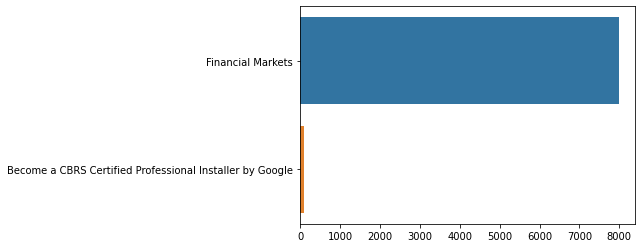

In [18]:
sns.barplot(x = top_reviewed_courses.head(10).values ,y =top_reviewed_courses.tail(10).index)

In [19]:
top_reviewed_institution = merged_reviews_courses.institution.value_counts()
top_reviewed_institution.head(10)

Yale University              7993
Google - Spectrum Sharing      87
Name: institution, dtype: int64

In [20]:
#Read data directly in spark a normal manner:
pathToFoler = "/gdrive/MyDrive/fa_project/"
fileName = "dataset.csv"
data = spark.read.csv(
                      path = pathToFoler + fileName,
                      inferSchema=True,
                      header=True
                      )

In [21]:
data.show()

+--------------------+--------------+------------+------+--------------------+
|             reviews|     reviewers|date_reviews|rating|           course_id|
+--------------------+--------------+------------+------+--------------------+
|Pretty dry, but I...|   By Robert S|Feb 12, 2020|     4|google-cbrs-cpi-t...|
|would be a better...|By Gabriel E R|Sep 28, 2020|     4|google-cbrs-cpi-t...|
|Information was p...|    By Jacob D|Apr 08, 2020|     4|google-cbrs-cpi-t...|
|A few grammatical...|     By Dale B|Feb 24, 2020|     4|google-cbrs-cpi-t...|
|Excellent course ...|     By Sean G|Jun 18, 2020|     4|google-cbrs-cpi-t...|
|Some of the quizz...|   By Daniel F|Dec 23, 2019|     4|google-cbrs-cpi-t...|
|Solid presentatio...|    By Logan D|Sep 03, 2020|     5|google-cbrs-cpi-t...|
|Probably the best...|   By Luis M C|Nov 21, 2019|     5|google-cbrs-cpi-t...|
|The ProctorU.com ...|    By scott w|Sep 28, 2020|     5|google-cbrs-cpi-t...|
|Covered all of th...|     By Ryan H|Aug 26, 2019|  

In [22]:
schema = StructType([ \
                     StructField("reviews",StringType(),True), \
                     StructField("reviewers",StringType(),True), \
                     StructField("date_reviews",StringType(),True), \
                     StructField("rating", StringType(), True), \
                     StructField("course_id", StringType(), True) \
  ])

In [23]:
trainDataset = spark.read  \
                 .option("quote", "\"") \
                 .option('escape', "\"") \
                 .option("multiLine", "true")  \
                 .option("schema" , schema)  \
                 .option("header", "true") \
                 .csv(pathToFoler + fileName)

In [24]:
trainDataset.show()
trainDataset.count()  

+--------------------+--------------+------------+------+--------------------+
|             reviews|     reviewers|date_reviews|rating|           course_id|
+--------------------+--------------+------------+------+--------------------+
|Pretty dry, but I...|   By Robert S|Feb 12, 2020|     4|google-cbrs-cpi-t...|
|would be a better...|By Gabriel E R|Sep 28, 2020|     4|google-cbrs-cpi-t...|
|Information was p...|    By Jacob D|Apr 08, 2020|     4|google-cbrs-cpi-t...|
|A few grammatical...|     By Dale B|Feb 24, 2020|     4|google-cbrs-cpi-t...|
|Excellent course ...|     By Sean G|Jun 18, 2020|     4|google-cbrs-cpi-t...|
|Some of the quizz...|   By Daniel F|Dec 23, 2019|     4|google-cbrs-cpi-t...|
|Solid presentatio...|    By Logan D|Sep 03, 2020|     5|google-cbrs-cpi-t...|
|Probably the best...|   By Luis M C|Nov 21, 2019|     5|google-cbrs-cpi-t...|
|The ProctorU.com ...|    By scott w|Sep 28, 2020|     5|google-cbrs-cpi-t...|
|Covered all of th...|     By Ryan H|Aug 26, 2019|  

8080

In [25]:
from pyspark.sql.functions import col

trainDataset.groupBy("rating") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+------+-----+
|rating|count|
+------+-----+
|     5| 6985|
|     4|  846|
|     3|  111|
|     1|   87|
|     2|   51|
+------+-----+



In [26]:
trainDataset = trainDataset.replace('1', 'Negative')
trainDataset = trainDataset.replace('2', 'Negative')
trainDataset = trainDataset.replace('3', 'Neutral')
trainDataset = trainDataset.replace('4', 'Positive')
trainDataset = trainDataset.replace('5', 'Positive')

In [27]:
trainDataset.groupBy("rating") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------+-----+
|  rating|count|
+--------+-----+
|Positive| 7831|
|Negative|  138|
| Neutral|  111|
+--------+-----+



In [28]:
(trainingData, testData) = trainDataset.randomSplit([0.8, 0.2], seed = 100)

print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 6476
Test Dataset Count: 1604


In [29]:
document_assembler = DocumentAssembler() \
    .setInputCol("reviews") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
    .setInputCols("normalized")\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)

lemma = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma")

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [30]:
glove_embeddings = WordEmbeddingsModel().pretrained() \
      .setInputCols(["document",'lemma'])\
      .setOutputCol("embeddings")\
      .setCaseSensitive(False)

embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["document", "embeddings"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE")

classsifierdl = ClassifierDLApproach()\
      .setInputCols(["sentence_embeddings"])\
      .setOutputCol("class")\
      .setLabelColumn("rating")\
      .setMaxEpochs(100)\
      .setEnableOutputLogs(True)

clf_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            lemma, 
            glove_embeddings,
            embeddingsSentence,
            classsifierdl])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [31]:
clf_pipelineModel = clf_pipeline.fit(trainingData)

In [32]:
preds = clf_pipelineModel.transform(testData)

In [33]:
preds.select('rating','reviews',"class.result").show(10, truncate=80)

+--------+--------------------------------------------------------------------------------+----------+
|  rating|                                                                         reviews|    result|
+--------+--------------------------------------------------------------------------------+----------+
|Positive|

The practical way to teach people who are hundreds of kilometers through vi...|[Positive]|
|Positive|
A course taught by a very valued teacher. I dont think theres is much to say...|[Positive]|
|Positive|                                       
EXCELENTE CURSO, MATERIAL Y DIDACTICA.

|[Positive]|
|Positive|     
It is a very necessary course. We should all take it. I really loved it.

|[Positive]|
|Positive|  Great course! It gives holistic understanding of Financial Markets. Lecture...|[Positive]|
|Positive|  I have really enjoyed attending the university, i have found the course is ...|[Positive]|
|Positive|  It is a very complete and interesting course. It covers all t

In [34]:
preds_df = preds.select('rating','reviews',"class.result").toPandas()

In [35]:
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

In [37]:
from sklearn.metrics import classification_report

print (classification_report(preds_df['result'], preds_df['rating']))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         0
     Neutral       0.00      0.00      0.00         0
    Positive       1.00      0.97      0.98      1604

    accuracy                           0.97      1604
   macro avg       0.33      0.32      0.33      1604
weighted avg       1.00      0.97      0.98      1604



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


BERT EMBEDDINGS

In [42]:
epochs = 7

document_assembler = DocumentAssembler() \
    .setInputCol("reviews") \
    .setOutputCol("document")
    
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")
      
bert_embeddings = BertEmbeddings().pretrained(name='small_bert_L4_256', lang='en') \
    .setInputCols(["document",'token'])\
    .setOutputCol("embeddings")

embeddingsSentence = SentenceEmbeddings() \
    .setInputCols(["document", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

classsifierdl = ClassifierDLApproach()\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("class")\
    .setLabelColumn("rating")\
    .setMaxEpochs(epochs)\
    .setLr(0.001)\
    .setBatchSize(8)\
    .setEnableOutputLogs(True)
    #.setOutputLogsPath('logs')

bert_clf_pipeline = Pipeline(stages=[
    document_assembler, 
    tokenizer,
    bert_embeddings,
    embeddingsSentence,
    classsifierdl
])

small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
[OK!]


In [43]:
bert_clf_pipelineModel = bert_clf_pipeline.fit(trainingData)

In [45]:
from sklearn.metrics import classification_report

preds = bert_clf_pipelineModel.transform(testData)

preds_df = preds.select('rating','reviews',"class.result").toPandas()

preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

print (classification_report(preds_df['result'], preds_df['rating']))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         0
     Neutral       0.00      0.00      0.00         0
    Positive       1.00      0.97      0.98      1604

    accuracy                           0.97      1604
   macro avg       0.33      0.32      0.33      1604
weighted avg       1.00      0.97      0.98      1604



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**CLASSIFER DL**

In [46]:
from sparknlp.base import *

# actual content is inside description column
document = DocumentAssembler()\
      .setInputCol("reviews")\
      .setOutputCol("document")

# we can also use sentece detector here if we want to train on and get predictions for each sentence
use = UniversalSentenceEncoder.pretrained("tfhub_use_lg", "en") \
      .setInputCols("document") \
      .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
classsifierdl = ClassifierDLApproach()\
      .setInputCols(["sentence_embeddings"])\
      .setOutputCol("class")\
      .setLabelColumn("rating")\
      .setMaxEpochs(3)\
      .setLr(0.001)\
      .setBatchSize(8)\
      .setEnableOutputLogs(True)

use_clf_pipeline = Pipeline(
    stages = [
        document,
        use,
        classsifierdl
    ])

tfhub_use_lg download started this may take some time.
Approximate size to download 753.3 MB
[OK!]


In [47]:
use_pipelineModel = use_clf_pipeline.fit(trainDataset)

In [48]:
# actual content is inside description column
document = DocumentAssembler()\
      .setInputCol("reviews")\
      .setOutputCol("document")
    
# we can also use sentece detector here if we want to train on and get predictions for each sentence

bert_sent = BertSentenceEmbeddings.pretrained('sent_small_bert_L8_512')\
      .setInputCols(["document"])\
      .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
classsifierdl = ClassifierDLApproach()\
      .setInputCols(["sentence_embeddings"])\
      .setOutputCol("class")\
      .setLabelColumn("rating")\
      .setMaxEpochs(10)\
      .setEnableOutputLogs(True)\
      .setLr(0.001)

bert_sent_clf_pipeline = Pipeline(
    stages = [
        document,
        bert_sent,
        classsifierdl
    ])

sent_small_bert_L8_512 download started this may take some time.
Approximate size to download 149.1 MB
[OK!]


In [50]:
bert_cmlm_pipelineModel = bert_sent_clf_pipeline.fit(trainDataset)

In [55]:
from sklearn.metrics import classification_report

preds = bert_cmlm_pipelineModel.transform(testData)

preds_df = preds.select('rating','reviews',"class.result").toPandas()

preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

print (classification_report(preds_df['result'], preds_df['rating']))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         0
     Neutral       0.00      0.00      0.00         0
    Positive       1.00      0.97      0.98      1604

    accuracy                           0.97      1604
   macro avg       0.33      0.32      0.33      1604
weighted avg       1.00      0.97      0.98      1604



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
